# Code for paper: *Why Do Pricing Rules Matter? Electricity Market Design with Electric Vehicle Participants.*

> Developed by Andrea Saumweber: a[dot]saumweber[at]moonroc[dot]de

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# 1. Data

In [2]:
# Scenarios
# S1: No Electric Vehicle (EV), No Demand Response (DR)
# S2: EV, No DR
# S3: EV, DR 

scenario = 'S3'


data = 'data/Data_EV_Paper_' + scenario + '.xlsx'

# Global Parameters
timestep = 1
big_M = 1000
eff_IN = 1
eff_OUT = 1

# Generation 
df_GEN = pd.read_excel(data, sheet_name="Generation Resources") 
G = set(df_GEN['Resource'])
T = set(t for t in range(0, max(df_GEN['Hour'])+1))
df_GEN.set_index(['Resource', 'Hour'], inplace=True)

# Demand
df_DEM = pd.read_excel(data, sheet_name="Demand Resources") 
D = set(df_DEM['Resource'])
df_DEM.set_index(['Resource', 'Hour'], inplace=True)

# Transmission
df_TRN = pd.read_excel(data, sheet_name="Transmission Lines")
N = set(df_TRN['Source'])
L = set([(df_TRN.loc[i]['Source'],df_TRN.loc[i]['Sink']) for i in range(0, len(df_TRN))])
df_TRN.set_index(['Source', 'Sink', 'Hour'], inplace=True)

# Electric Vehicles
df_EV = pd.read_excel(data, sheet_name="Electric Vehicles")
V = set(df_EV['Vehicle'])
df_EV.set_index(['Vehicle', 'Hour'], inplace=True)

# 2. Model
## 2.1 Allocation Models
### 2.1.1 Market Model

In [3]:
# setup model
ucm = pywraplp.Solver.CreateSolver('SCIP')
infinity = ucm.infinity()

# define variables
q_GEN = {(g,t): ucm.NumVar(0.0, infinity, "q_GEN"+str(g)+str(t)) for g in G for t in T}
u_GEN = {(g,t): ucm.IntVar(0.0, 1.0, "u_GEN"+str(g)+str(t)) for g in G for t in T}
q_ELA = {(d,t): ucm.NumVar(0.0, infinity, "q_ELA"+str(d)+str(t)) for d in D for t in T}
u_DEM = {(d,t): ucm.IntVar(0.0, 1.0, "u_DEM"+str(d)+str(t)) for d in D for t in T}
q_IN_EV = {(v,t): ucm.NumVar(0.0, infinity, "q_IN_EV"+str(v)+str(t)) for v in V for t in T}
q_OUT_EV = {(v,t): ucm.NumVar(0.0, infinity, "q_OUT_EV"+str(v)+str(t)) for v in V for t in T}
soc_EV = {(v,t): ucm.NumVar(0.0, infinity, "soc_EV"+str(v)+str(t)) for v in V for t in T}
m_EV = {(v,t): ucm.IntVar(0.0, 1.0, "m_EV"+str(v)+str(t)) for v in V for t in T}
q_TRN = {(n, m, t): ucm.NumVar(-infinity, infinity, "q_TRN"+str(n)+str(m)+str(t)) for (n, m) in L for t in T}
d_TRN = {(n, t): ucm.NumVar(-infinity, infinity, "d_TRN"+str(n)+str(t)) for n in N for t in T}

# define constraints
output_GEN = {(g, t): ucm.Add(df_GEN.at[(g, t),'Q_MIN (MW)'] * u_GEN[g, t] <= q_GEN[g, t] <= df_GEN.at[(g, t),'Q_MAX (MW)'] * u_GEN[g, t]) for g in G for t in T}
output_DEM = {(d, t): ucm.Add(df_DEM.at[(d, t),'Q_MIN (MW)'] * u_DEM[d, t] <= q_ELA[d, t] + df_DEM.at[(d, t),'Q_FIX (MWh)']  <= df_DEM.at[(d, t),'Q_MAX (MW)'] * u_DEM[d, t]) for d in D for t in T}
soc_def_EV = {(v, t): ucm.Add(soc_EV[v, t] == soc_EV[v, t-1] + eff_IN * q_IN_EV[v, t] - (1/eff_OUT) * q_OUT_EV[v, t] - df_EV.at[(v, t), 'D_SOC_EV (MWh)']) for v in V for t in range(1, max(T)+1)}
soc_def_EV2 = {(v, 0): ucm.Add(soc_EV[v, 0]==df_EV.at[(v, 0), 'SOC_EV_MAX (MWh)'] + eff_IN * q_IN_EV[v, 0] - (1/eff_OUT) * q_OUT_EV[v, 0] - df_EV.at[(v, 0), 'D_SOC_EV (MWh)']) for v in V}
soc_def_EV3 = {(v, max(T)): ucm.Add(soc_EV[v, max(T)]==df_EV.at[(v, max(T)), 'SOC_EV_MAX (MWh)']) for v in V}
soc_capacity_EV = {(v, t): ucm.Add(df_EV.at[(v, t), 'SOC_EV_MIN (MWh)'] <= soc_EV[v, t] <= df_EV.at[(v, t), 'SOC_EV_MAX (MWh)']) for v in V for t in T}
charging_speed_EV = {(v, t): ucm.Add(q_IN_EV[v, t] + q_OUT_EV[v, t] <= df_EV.at[(v, t), 'Q_MAX (MW)']) for v in V for t in T}
charging_mode_1_EV = {(v, t): ucm.Add(q_IN_EV[v, t] <= big_M * m_EV[v, t]) for v in V for t in T}
charging_mode_2_EV = {(v, t): ucm.Add(q_OUT_EV[v, t] <= big_M * (1 - m_EV[v, t])) for v in V for t in T}
capacity_TRAN = {(n, m, t): ucm.Add(-df_TRN.at[(n, m, t), 'Q_MAX (MW)'] <= q_TRN[n, m, t] <= df_TRN.at[(n, m, t), 'Q_MAX (MW)']) for (n, m) in L for t in T}
second_law = {((n,m), t): ucm.Add(q_TRN[n, m, t] == -df_TRN.at[(n, m, t), 'B'] * (d_TRN[n, t] - d_TRN[m, t])) for (n,m) in L for t in T}
second_law_fix = {t: ucm.Add(d_TRN["N1", t] == 0) for t in T}
first_law = {(n, t): ucm.Add(sum(q_GEN[g, t] for g in G if df_GEN.at[(g, t), 'Node']==n)
                             + sum(q_OUT_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)
                             - sum(df_DEM.at[(d, t),'Q_FIX (MWh)']+q_ELA[d, t] for d in D if df_DEM.at[(d, t), 'Node']==n)
                             - sum(q_IN_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)   
                             + sum(q_TRN[n_, m, t] for (n_, m) in L if n_ == n) == 0) for n in N for t in T}

# define objective
objective = ucm.Minimize(sum(df_GEN.at[(g, t),'C_Q ($/MWh)'] * q_GEN[g, t] 
                             + df_GEN.at[(g, t),'C_U ($/h)'] * u_GEN[g, t] for g in G for t in T) 
                         - sum(df_DEM.at[(d, t),'C_Q ($/MWh)'] * q_ELA[d, t] for d in D for t in T))

In [4]:
# solve model
status = ucm.Solve()

if status == pywraplp.Solver.OPTIMAL: 
    print('... allocation computed', "\n")
    
    MARKET_RESULTS_GEN = pd.DataFrame(columns=['Resource', 'Hour', 'Node', 'q', 'u'])
    MARKET_RESULTS_GEN.set_index(['Resource', 'Hour'], inplace=True)
    MARKET_RESULTS_GEN.sort_values(by=['Resource', 'Hour'],inplace=True)
    for t in T:
        for g in G:
            MARKET_RESULTS_GEN.at[(g, t), 'q'] = q_GEN[g, t].solution_value()
            MARKET_RESULTS_GEN.at[(g, t), 'u'] = u_GEN[g, t].solution_value()
            MARKET_RESULTS_GEN.at[(g, t), 'Node'] = df_GEN.at[(g, t), 'Node']
            
    MARKET_RESULTS_TRN = pd.DataFrame(columns=['Source', 'Sink', 'Hour', 'q', 'delta'])
    MARKET_RESULTS_TRN.set_index(['Source', 'Sink', 'Hour'], inplace=True)
    MARKET_RESULTS_TRN.sort_index() 
    for t in T:
        for (n, m) in L:
            MARKET_RESULTS_TRN.at[(n, m, t), 'q'] = q_TRN[n, m, t].solution_value()
            MARKET_RESULTS_TRN.at[(n, m, t), 'delta'] = d_TRN[n, t].solution_value()
    '''print(MARKET_RESULTS_TRN)'''
            
            
    MARKET_RESULTS_DEM = pd.DataFrame(columns=['Resource', 'Hour', 'Node', 'q', 'u'])
    MARKET_RESULTS_DEM.set_index(['Resource', 'Hour'], inplace=True)
    MARKET_RESULTS_DEM.sort_values(by=['Resource', 'Hour'],inplace=True)
    for t in T:
        for d in D:
            MARKET_RESULTS_DEM.at[(d, t), 'q'] = q_ELA[d, t].solution_value()
            MARKET_RESULTS_DEM.at[(d, t), 'u'] = u_DEM[d, t].solution_value()
            MARKET_RESULTS_DEM.at[(d, t), 'Node'] = df_DEM.at[(d, t), 'Node']
            
    MARKET_RESULTS_EV = pd.DataFrame(columns=['Vehicle', 'Hour', 'Node', 'q_in', 'q_out', 'soc', 'm'])
    MARKET_RESULTS_EV.set_index(['Vehicle', 'Hour'], inplace=True)
    MARKET_RESULTS_EV.sort_values(by=['Vehicle', 'Hour'],inplace=True) 
    for t in T:
        for v in V:
            MARKET_RESULTS_EV.at[(v, t), 'q_in'] = q_IN_EV[v, t].solution_value()
            MARKET_RESULTS_EV.at[(v, t), 'q_out'] = q_OUT_EV[v, t].solution_value()
            MARKET_RESULTS_EV.at[(v, t), 'soc'] = soc_EV[v, t].solution_value()
            MARKET_RESULTS_EV.at[(v, t), 'm'] = m_EV[v, t].solution_value()
            MARKET_RESULTS_EV.at[(v, t), 'Node'] = df_EV.at[(v, t), 'Node']
            

    MARKET_RESULTS_OBJECTIVE = ucm.Objective().Value()
else:
    print('The problem does not have an optimal solution.')

... allocation computed 



/Users/felipe/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
MARKET_RESULTS_NODE = pd.DataFrame(columns=['Node', 'Hour', 'Generation', 'Demand'])
MARKET_RESULTS_NODE.set_index(['Node', 'Hour'], inplace=True)
for n in N:
    for t in T:
        MARKET_RESULTS_NODE.at[(n, t), 'Generation'] = (sum(MARKET_RESULTS_GEN.at[(g, t), 'q'] for g in G if df_GEN.at[(g, t), 'Node']==n) 
                                                        + sum(MARKET_RESULTS_EV.at[(v, t), 'q_out'] for v in V if df_EV.at[(v, t), 'Node']==n))
        MARKET_RESULTS_NODE.at[(n, t), 'Demand'] = (sum(MARKET_RESULTS_DEM.at[(d, t), 'q'] for d in D if df_DEM.at[(d, t), 'Node']==n) + 
                                                    sum(df_DEM.at[(d, t),'Q_FIX (MWh)'] for d in D if df_DEM.at[(d, t), 'Node']==n)
                                                   + sum(MARKET_RESULTS_EV.at[(v, t), 'q_in'] for v in V if df_EV.at[(v, t), 'Node']==n))

### 2.1.2 Self-Schedules

In [6]:
# GENERATION RESOURCE
def f_self_GEN(g, n, market_prices, market_uplifts=None):
    
    # setup model
    self_GEN = pywraplp.Solver.CreateSolver('SCIP')
    infinity = self_GEN.infinity()
    # define variables
    self_q_GEN = {t: self_GEN.NumVar(0.0, infinity, "q_GEN"+str(t)) for t in T}
    self_u_GEN = {t: self_GEN.IntVar(0.0, 1.0, "u_GEN"+str(t)) for t in T}
    # define constraints
    output_GEN = {t: self_GEN.Add(df_GEN.at[(g, t),'Q_MIN (MW)'] * self_u_GEN[t] <= self_q_GEN[t] <= df_GEN.at[(g, t),'Q_MAX (MW)'] * self_u_GEN[t]) for t in T}
    # define objective
    if market_uplifts is None:
        objective = self_GEN.Maximize(sum(market_prices.at[(n,t), 'Price'] * self_q_GEN[t]
                                          - df_GEN.at[(g, t),'C_Q ($/MWh)']  * self_q_GEN[t]
                                          - df_GEN.at[(g, t),'C_U ($/h)']  * self_u_GEN[t] for t in T))
    else:
        objective = self_GEN.Maximize(sum(market_prices.at[(n,t), 'Price'] * self_q_GEN[t]
                                          - df_GEN.at[(g, t),'C_Q ($/MWh)']  * self_q_GEN[t]
                                          - df_GEN.at[(g, t),'C_U ($/h)']  * self_u_GEN[t]
                                          + market_uplifts.at[(g, t),'Uplift Coefficient']  * self_u_GEN[t] for t in T))
    # solve model
    status = self_GEN.Solve()
    if status == pywraplp.Solver.OPTIMAL: 
        # print('... allocation computed for', g, "\n")
        index = pd.MultiIndex.from_tuples([(g, t) for t in T], names=["Resource", "Hour"])
        SELF_RESULTS_GEN = pd.DataFrame(index=index, columns=['q', 'u'])
        for t in T:
            SELF_RESULTS_GEN.at[(g, t),'q'] = self_q_GEN[t].solution_value()
            SELF_RESULTS_GEN.at[(g, t),'u'] = self_u_GEN[t].solution_value()
        return self_GEN.Objective().Value(), SELF_RESULTS_GEN
    else:
        print('... failure at', g, "\n")

In [7]:
# DEMAND RESOURCE
def f_self_DEM(g, n, market_prices, market_uplifts=None):
    # setup model
    self_DEM = pywraplp.Solver.CreateSolver('SCIP')
    infinity = self_DEM.infinity()
    # define variables
    self_q_ELA = {t: self_DEM.NumVar(0.0, infinity, "q_ELA"+str(t)) for t in T}
    self_u_DEM = {t: self_DEM.IntVar(0.0, 1.0, "u_DEM"+str(t)) for t in T}
    # define constraints
    output_DEM = {t: self_DEM.Add(df_DEM.at[(d, t),'Q_MIN (MW)'] * self_u_DEM[t] <= self_q_ELA[t] + df_DEM.at[(d, t),'Q_FIX (MWh)']  <= df_DEM.at[(d, t),'Q_MAX (MW)'] * self_u_DEM[t]) for t in T}
    # define objective
    if market_uplifts is None:
        objective = self_DEM.Maximize(sum(df_DEM.at[(d, t),'C_Q ($/MWh)']  * self_q_ELA[t] -
                                          market_prices.at[(n,t), 'Price'] * self_q_ELA[t] for t in T))
    else:
        objective = self_DEM.Maximize(sum(df_DEM.at[(d, t),'C_Q ($/MWh)']  * self_q_ELA[t] -
                                          market_prices.at[(n,t), 'Price'] * self_q_ELA[t] +
                                          market_uplifts.at[(d,t), 'Uplift Coefficient'] * self_q_ELA[t] for t in T))
    # solve model
    status = self_DEM.Solve()
    if status == pywraplp.Solver.OPTIMAL: 
        # print('... allocation computed for', g, "\n")
        index = pd.MultiIndex.from_tuples([(g, t) for t in T], names=["Resource", "Hour"])
        SELF_RESULTS_DEM = pd.DataFrame(index=index, columns=['q', 'u'])
        for t in T:
            SELF_RESULTS_DEM.at[(d, t),'q'] = self_q_ELA[t].solution_value()
            SELF_RESULTS_DEM.at[(d, t),'u'] = self_u_DEM[t].solution_value()
        return self_DEM.Objective().Value(), SELF_RESULTS_DEM
    else:
        print('... failure at', g, "\n")

## 2.2 Pricing Model
### 2.2.1 IP Pricing

In [8]:
# setup model
ippm = pywraplp.Solver.CreateSolver('GLOP')
infinity = ippm.infinity()

# define variables
q_GEN = {(g,t): ippm.NumVar(0.0, infinity, "q_GEN"+str(g)+str(t)) for g in G for t in T}
u_GEN = {(g,t): ippm.NumVar(0.0, infinity, "u_GEN"+str(g)+str(t)) for g in G for t in T}
q_ELA = {(d,t): ippm.NumVar(0.0, infinity, "q_ELA"+str(d)+str(t)) for d in D for t in T}
u_DEM = {(d,t): ippm.NumVar(0.0, infinity, "u_DEM"+str(d)+str(t)) for d in D for t in T}
q_IN_EV = {(v,t): ippm.NumVar(0.0, infinity, "q_IN_EV"+str(v)+str(t)) for v in V for t in T}
q_OUT_EV = {(v,t): ippm.NumVar(0.0, infinity, "q_OUT_EV"+str(v)+str(t)) for v in V for t in T}
soc_EV = {(v,t): ippm.NumVar(0.0, infinity, "soc_EV"+str(v)+str(t)) for v in V for t in T}
m_EV = {(v,t): ippm.NumVar(0.0, infinity, "m_EV"+str(v)+str(t)) for v in V for t in T}
q_TRN = {(n, m, t): ippm.NumVar(-infinity, infinity, "q_TRN"+str(n)+str(m)+str(t)) for (n, m) in L for t in T}
d_TRN = {(n, t): ippm.NumVar(-infinity, infinity, "d_TRN"+str(n)+str(t)) for n in N for t in T}

# define constraints
fixed_GEN = {(g, t): ippm.Add(u_GEN[g, t] == MARKET_RESULTS_GEN.at[(g, t),'u']) for g in G for t in T}
fixed_DEM = {(d, t): ippm.Add(u_DEM[d, t] == MARKET_RESULTS_DEM.at[(d, t),'u']) for d in D for t in T}
fixed_EV = {(v, t): ippm.Add(m_EV[v, t] == MARKET_RESULTS_EV.at[(v, t), 'm']) for v in V for t in T}

output_GEN = {(g, t): ippm.Add(df_GEN.at[(g, t),'Q_MIN (MW)'] * u_GEN[g, t] <= q_GEN[g, t] <= df_GEN.at[(g, t),'Q_MAX (MW)'] * u_GEN[g, t]) for g in G for t in T}
output_DEM = {(d, t): ippm.Add(df_DEM.at[(d, t),'Q_MIN (MW)'] * u_DEM[d, t] <= q_ELA[d, t] + df_DEM.at[(d, t),'Q_FIX (MWh)']  <= df_DEM.at[(d, t),'Q_MAX (MW)'] * u_DEM[d, t]) for d in D for t in T}
soc_def_EV = {(v, t): ippm.Add(soc_EV[v, t] == soc_EV[v, t-1] + eff_IN * q_IN_EV[v, t] - (1/eff_OUT) * q_OUT_EV[v, t] - df_EV.at[(v, t), 'D_SOC_EV (MWh)']) for v in V for t in range(1, max(T)+1)}
soc_def_EV2 = {(v, 0): ippm.Add(soc_EV[v, 0]==df_EV.at[(v, 0), 'SOC_EV_MAX (MWh)'] + eff_IN * q_IN_EV[v, 0] - (1/eff_OUT) * q_OUT_EV[v, 0] - df_EV.at[(v, 0), 'D_SOC_EV (MWh)']) for v in V}
soc_def_EV3 = {(v, max(T)): ippm.Add(soc_EV[v, max(T)]==df_EV.at[(v, max(T)), 'SOC_EV_MAX (MWh)']) for v in V}
soc_capacity_EV = {(v, t): ippm.Add(df_EV.at[(v, t), 'SOC_EV_MIN (MWh)'] <= soc_EV[v, t] <= df_EV.at[(v, t), 'SOC_EV_MAX (MWh)']) for v in V for t in T}
charging_speed_EV = {(v, t): ippm.Add(q_IN_EV[v, t] + q_OUT_EV[v, t] <= df_EV.at[(v, t), 'Q_MAX (MW)']) for v in V for t in T}
charging_mode_1_EV = {(v, t): ippm.Add(q_IN_EV[v, t] <= big_M * m_EV[v, t]) for v in V for t in T}
charging_mode_2_EV = {(v, t): ippm.Add(q_OUT_EV[v, t] <= big_M * (1 - m_EV[v, t])) for v in V for t in T}
capacity_TRAN = {(n, m, t): ippm.Add(-df_TRN.at[(n, m, t), 'Q_MAX (MW)'] <= q_TRN[n, m, t] <= df_TRN.at[(n, m, t), 'Q_MAX (MW)']) for (n, m) in L for t in T}
second_law = {((n,m), t): ippm.Add(q_TRN[n, m, t] == -df_TRN.at[(n, m, t), 'B'] * (d_TRN[n, t] - d_TRN[m, t])) for (n,m) in L for t in T}
second_law_fix = {t: ippm.Add(d_TRN["N1", t] == 0) for t in T}
first_law = {(n, t): ippm.Add(sum(q_GEN[g, t] for g in G if df_GEN.at[(g, t), 'Node']==n)
                             + sum(q_OUT_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)
                             - sum(df_DEM.at[(d, t),'Q_FIX (MWh)']+q_ELA[d, t] for d in D if df_DEM.at[(d, t), 'Node']==n)
                             - sum(q_IN_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)   
                             + sum(q_TRN[n_, m, t] for (n_, m) in L if n_ == n) == 0) for n in N for t in T}

# define objective
objective = ippm.Minimize(sum(df_GEN.at[(g, t),'C_Q ($/MWh)'] * q_GEN[g, t] 
                             + df_GEN.at[(g, t),'C_U ($/h)'] * u_GEN[g, t] for g in G for t in T) 
                         - sum(df_DEM.at[(d, t),'C_Q ($/MWh)'] * q_ELA[d, t] for d in D for t in T))

In [9]:
# solve model
status = ippm.Solve()

if status == pywraplp.Solver.OPTIMAL: 
    print('... ip pricing computed', "\n")
    # calculate prices
    ip_prices = pd.DataFrame([[n, t, first_law[n, t].dual_value()] for n in N for t in T], columns=['Node', 'Hour', 'Price'])
    ip_prices.set_index(['Node', 'Hour'], inplace=True)
    # calculate uplifts
    ip_uplifts = pd.DataFrame(columns=['Resource', 'Hour', 'Uplift', 'Uplift+', 'Uplift Coefficient'])
    ip_uplifts.set_index(['Resource', 'Hour'], inplace=True)
    for t in T:
        for g in G:
            ip_uplifts.at[(g, t), 'Uplift'] = fixed_GEN[g, t].dual_value() * u_GEN[g, t].solution_value()
            ip_uplifts.at[(g, t), 'Uplift+'] = max(0,fixed_GEN[g, t].dual_value() * u_GEN[g, t].solution_value())
            ip_uplifts.at[(g, t), 'Uplift Coefficient'] = fixed_GEN[g, t].dual_value()
        for d in D:
            ip_uplifts.at[(d, t), 'Uplift'] = output_DEM[d, t].dual_value() * q_ELA[d, t].solution_value()
            ip_uplifts.at[(d, t), 'Uplift+'] = max(0,output_DEM[d, t].dual_value() * q_ELA[d, t].solution_value())
            ip_uplifts.at[(d, t), 'Uplift Coefficient'] = output_DEM[d, t].dual_value()
    
    ip_uplifts_grouped = pd.DataFrame(columns=['Resource', 'Uplift', 'Uplift+'])
    ip_uplifts_grouped.set_index(['Resource'], inplace=True)
    for i in G.union(D):
        ip_uplifts_grouped.at[i, 'Uplift'] = sum(ip_uplifts.at[(i, t), 'Uplift'] for t in T)
        ip_uplifts_grouped.at[i, 'Uplift+'] = sum(ip_uplifts.at[(i, t), 'Uplift+'] for t in T)
else: 
    print('The problem does not have an optimal solution.')

... ip pricing computed 



### 2.2.2 ELM Pricing

In [10]:
# setup model
elmpm = pywraplp.Solver.CreateSolver('GLOP')
infinity = elmpm.infinity()

# define variables
q_GEN = {(g,t): elmpm.NumVar(0.0, infinity, "q_GEN"+str(g)+str(t)) for g in G for t in T}
u_GEN = {(g,t): elmpm.NumVar(0.0, 1.0, "u_GEN"+str(g)+str(t)) for g in G for t in T}
q_ELA = {(d,t): elmpm.NumVar(0.0, infinity, "q_ELA"+str(d)+str(t)) for d in D for t in T}
u_DEM = {(d,t): elmpm.NumVar(0.0, 1.0, "u_DEM"+str(d)+str(t)) for d in D for t in T}
q_IN_EV = {(v,t): elmpm.NumVar(0.0, infinity, "q_IN_EV"+str(v)+str(t)) for v in V for t in T}
q_OUT_EV = {(v,t): elmpm.NumVar(0.0, infinity, "q_OUT_EV"+str(v)+str(t)) for v in V for t in T}
soc_EV = {(v,t): elmpm.NumVar(0.0, infinity, "soc_EV"+str(v)+str(t)) for v in V for t in T}
m_EV = {(v,t): elmpm.NumVar(0.0, 1.0, "m_EV"+str(v)+str(t)) for v in V for t in T}
q_TRN = {(n, m, t): elmpm.NumVar(-infinity, infinity, "q_TRN"+str(n)+str(m)+str(t)) for (n, m) in L for t in T}
d_TRN = {(n, t): elmpm.NumVar(-infinity, infinity, "d_TRN"+str(n)+str(t)) for n in N for t in T}

# define constraints
output_GEN = {(g, t): elmpm.Add(df_GEN.at[(g, t),'Q_MIN (MW)'] * u_GEN[g, t] <= q_GEN[g, t] <= df_GEN.at[(g, t),'Q_MAX (MW)'] * u_GEN[g, t]) for g in G for t in T}
output_DEM = {(d, t): elmpm.Add(df_DEM.at[(d, t),'Q_MIN (MW)'] * u_DEM[d, t] <= q_ELA[d, t] + df_DEM.at[(d, t),'Q_FIX (MWh)']  <= df_DEM.at[(d, t),'Q_MAX (MW)'] * u_DEM[d, t]) for d in D for t in T}
soc_def_EV = {(v, t): elmpm.Add(soc_EV[v, t] == soc_EV[v, t-1] + eff_IN * q_IN_EV[v, t] - (1/eff_OUT) * q_OUT_EV[v, t] - df_EV.at[(v, t), 'D_SOC_EV (MWh)']) for v in V for t in range(1, max(T)+1)}
soc_def_EV2 = {(v, 0): elmpm.Add(soc_EV[v, 0]==df_EV.at[(v, 0), 'SOC_EV_MAX (MWh)'] + eff_IN * q_IN_EV[v, 0] - (1/eff_OUT) * q_OUT_EV[v, 0] - df_EV.at[(v, 0), 'D_SOC_EV (MWh)']) for v in V}
soc_def_EV3 = {(v, max(T)): elmpm.Add(soc_EV[v, max(T)]==df_EV.at[(v, max(T)), 'SOC_EV_MAX (MWh)']) for v in V}
soc_capacity_EV = {(v, t): elmpm.Add(df_EV.at[(v, t), 'SOC_EV_MIN (MWh)'] <= soc_EV[v, t] <= df_EV.at[(v, t), 'SOC_EV_MAX (MWh)']) for v in V for t in T}
charging_speed_EV = {(v, t): elmpm.Add(q_IN_EV[v, t] + q_OUT_EV[v, t] <= df_EV.at[(v, t), 'Q_MAX (MW)']) for v in V for t in T}
charging_mode_1_EV = {(v, t): elmpm.Add(q_IN_EV[v, t] <= big_M * m_EV[v, t]) for v in V for t in T}
charging_mode_2_EV = {(v, t): elmpm.Add(q_OUT_EV[v, t] <= big_M * (1 - m_EV[v, t])) for v in V for t in T}
capacity_TRAN = {(n, m, t): elmpm.Add(-df_TRN.at[(n, m, t), 'Q_MAX (MW)'] <= q_TRN[n, m, t] <= df_TRN.at[(n, m, t), 'Q_MAX (MW)']) for (n, m) in L for t in T}
second_law = {((n,m), t): elmpm.Add(q_TRN[n, m, t] == -df_TRN.at[(n, m, t), 'B'] * (d_TRN[n, t] - d_TRN[m, t])) for (n,m) in L for t in T}
second_law_fix = {t: elmpm.Add(d_TRN["N1", t] == 0) for t in T}
first_law = {(n, t): elmpm.Add(sum(q_GEN[g, t] for g in G if df_GEN.at[(g, t), 'Node']==n)
                             + sum(q_OUT_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)
                             - sum(df_DEM.at[(d, t),'Q_FIX (MWh)']+q_ELA[d, t] for d in D if df_DEM.at[(d, t), 'Node']==n)
                             - sum(q_IN_EV[v, t] for v in V if df_EV.at[(v, t), 'Node']==n)   
                             + sum(q_TRN[n_, m, t] for (n_, m) in L if n_ == n) == 0) for n in N for t in T}

# define objective
objective = elmpm.Minimize(sum(df_GEN.at[(g, t),'C_Q ($/MWh)'] * q_GEN[g, t] 
                             + df_GEN.at[(g, t),'C_U ($/h)'] * u_GEN[g, t] for g in G for t in T) 
                         - sum(df_DEM.at[(d, t),'C_Q ($/MWh)'] * q_ELA[d, t] for d in D for t in T))

In [11]:
# solve model
status = elmpm.Solve()

if status == pywraplp.Solver.OPTIMAL: 
    print('... elm pricing computed', "\n")
    # calculate prices
    elmp_prices = pd.DataFrame([[n, t, first_law[n, t].dual_value()] for n in N for t in T], columns=['Node', 'Hour', 'Price'])
    elmp_prices.set_index(['Node', 'Hour'], inplace=True)
    
    # calculate uplifts
    elmp_uplifts = pd.DataFrame(columns=['Resource', 'Uplift'])
    elmp_uplifts.set_index('Resource', inplace=True)
    for n in N:
        for g in G:
            if df_GEN.at[(g, t), 'Node']==n:
                objective, schedule = f_self_GEN(g, n, elmp_prices)
                elmp_uplifts.at[g, 'Uplift'] = (objective 
                                                - sum(elmp_prices.at[(n, t), 'Price'] * MARKET_RESULTS_GEN.at[(g, t), 'q'] 
                                                      - df_GEN.at[(g, t),'C_Q ($/MWh)'] * MARKET_RESULTS_GEN.at[(g, t), 'q'] 
                                                      - df_GEN.at[(g, t),'C_U ($/h)'] * MARKET_RESULTS_GEN.at[(g, t), 'u'] for t in T))
        for d in D: 
             if df_DEM.at[(d, t), 'Node']==n:
                objective, schedule = f_self_DEM(d, n, elmp_prices)
                elmp_uplifts.at[d, 'Uplift'] = (objective 
                                                - sum(df_DEM.at[(d, t),'C_Q ($/MWh)'] * MARKET_RESULTS_DEM.at[(d, t), 'q'] 
                                                      - elmp_prices.at[(n, t), 'Price'] *  MARKET_RESULTS_DEM.at[(d, t), 'q'] for t in T))
else:
    print('The problem does not have an optimal solution.')

... elm pricing computed 



# 3 Results

## 3.1 Data

In [12]:
MARKET_RESULTS_PRICES = pd.DataFrame(columns=['Node', 'Hour'])
MARKET_RESULTS_PRICES.set_index(['Node', 'Hour'], inplace=True)

MARKET_RESULTS_PRICES['IP Prices'] = ip_prices['Price']
MARKET_RESULTS_PRICES['IP+ Prices'] = ip_prices['Price']
MARKET_RESULTS_PRICES['ELM Prices'] = elmp_prices['Price']

MARKET_RESULTS_PRICES.sort_values(by=['Node', 'Hour'],inplace=True)
MARKET_RESULTS_PRICES

IP Prices  IP+ Prices  ELM Prices
Node Hour                                   
N1   0          10.0        10.0        10.2
     1          10.0        10.0        10.2
     2          10.0        10.0        10.2
     3          10.0        10.0        10.2
     4          10.0        10.0        10.2
     5          10.0        10.0        10.2
     6          10.0        10.0        10.2
     7          10.0        10.0        10.2
     8          10.0        10.0        10.2
     9          10.0        10.0        10.2
     10         10.0        10.0        10.2
     11         10.0        10.0        10.2
     12         10.0        10.0        10.2
     13         10.0        10.0        10.2
     14         10.0        10.0        10.2
     15         10.0        10.0        10.2
     16         10.0        10.0        10.2
     17         10.0        10.0        10.2
     18         10.0        10.0        10.2
     19         10.0        10.0        10.2
     20         10.0        10.0        10.2
     21         10.0        10.0        10.2
     22         10.0        10.0        10.2
     23         10.0        10.0        10.2
N2   0          13.0        13.0        13.1
     1          13.0        13.0        13.1
     2          13.0        13.0        13.1
     3          13.0        13.0        13.1
     4          13.0        13.0        13.1
     5          13.0        13.0        13.1
     6          14.2        14.2        14.3
     7          14.2        14.2        14.3
     8          15.4        15.4        15.5
     9          15.4        15.4        15.5
     10         15.4        15.4        15.5
     11         15.4        15.4        15.5
     12         15.4        15.4        15.5
     13         15.4        15.4        15.5
     14         15.4        15.4        15.5
     15         15.4        15.4        15.5
     16         15.4        15.4        15.5
     17         15.4        15.4        15.5
     18         15.4        15.4        15.5
     19         15.4        15.4        15.5
     20         15.4        15.4        15.5
     21         15.4        15.4        15.5
     22         15.4        15.4        15.5
     23         15.4        15.4        15.5
N3   0          16.0        16.0        16.0
     1          16.0        16.0        16.0
     2          16.0        16.0        16.0
     3          16.0        16.0        16.0
     4          16.0        16.0        16.0
     5          16.0        16.0        16.0
     6          18.4        18.4        18.4
     7          18.4        18.4        18.4
     8          20.8        20.8        20.8
     9          20.8        20.8        20.8
     10         20.8        20.8        20.8
     11         20.8        20.8        20.8
     12         20.8        20.8        20.8
     13         20.8        20.8        20.8
     14         20.8        20.8        20.8
     15         20.8        20.8        20.8
     16         20.8        20.8        20.8
     17         20.8        20.8        20.8
     18         20.8        20.8        20.8
     19         20.8        20.8        20.8
     20         20.8        20.8        20.8
     21         20.8        20.8        20.8
     22         20.8        20.8        20.8
     23         20.8        20.8        20.8

In [13]:
MARKET_RESULTS_UPLIFTS = pd.DataFrame(columns=['Resource'])
MARKET_RESULTS_UPLIFTS.set_index(['Resource'], inplace=True)
MARKET_RESULTS_UPLIFTS['IP Uplift'] = ip_uplifts_grouped['Uplift']
MARKET_RESULTS_UPLIFTS['IP+ Uplift'] = ip_uplifts_grouped['Uplift+']
MARKET_RESULTS_UPLIFTS['ELM Uplift'] = elmp_uplifts['Uplift']
MARKET_RESULTS_UPLIFTS.sort_values(by=['Resource'],inplace=True)
MARKET_RESULTS_UPLIFTS

,IP Uplift,IP+ Uplift,ELM Uplift
Resource,,,
D2,0.0,0,0.0
D3.1,-1442.874696,0,0.0
D3.2,-646.442295,0,0.0
D3.3,0.0,0,0.0
D3.4,0.0,0,0.0
D3.5,0.0,0,0.0
G1,2160.0,2160.0,139.04729
G2,0.0,0,0.0
G3,0.0,0,0.0


In [14]:
# profit / loss
def f1_profit_GEN(g, n, market_prices, market_uplifts):
    profit = (sum(market_prices.at[(n,t), 'Price'] * MARKET_RESULTS_GEN.at[(g, t), 'q'] for t in T) 
              - sum(df_GEN.at[(g, t),'C_Q ($/MWh)']  * MARKET_RESULTS_GEN.at[(g, t), 'q'] for t in T) 
              - sum(df_GEN.at[(g, t),'C_U ($/h)']  * MARKET_RESULTS_GEN.at[(g, t), 'u'] for t in T) 
             + market_uplifts.at[g, 'Uplift'])
    return profit

def f2_profit_GEN(g, n, market_prices, market_uplifts):
    profit = (sum(market_prices.at[(n,t), 'Price'] * MARKET_RESULTS_GEN.at[(g, t), 'q'] for t in T) 
              - sum(df_GEN.at[(g, t),'C_Q ($/MWh)']  * MARKET_RESULTS_GEN.at[(g, t), 'q'] for t in T) 
              - sum(df_GEN.at[(g, t),'C_U ($/h)']  * MARKET_RESULTS_GEN.at[(g, t), 'u'] for t in T)
              + sum(market_uplifts.at[(g, t),'Uplift'] for t in T))
    return profit 

def f1_profit_DEM(d, n, market_prices, market_uplifts):
    profit = (sum(df_DEM.at[(d, t),'C_Q ($/MWh)']  * MARKET_RESULTS_DEM.at[(d, t), 'q']
                  - market_prices.at[(n,t), 'Price'] * MARKET_RESULTS_DEM.at[(d, t), 'q'] for t in T)
             + market_uplifts.at[d, 'Uplift'])
    return profit

def f2_profit_DEM(d, n, market_prices, market_uplifts):
    profit = (sum(df_DEM.at[(d, t),'C_Q ($/MWh)']  * MARKET_RESULTS_DEM.at[(d, t), 'q']
                  - market_prices.at[(n,t), 'Price'] * MARKET_RESULTS_DEM.at[(d, t), 'q'] for t in T)
              + sum(market_uplifts.at[(d, t),'Uplift'] for t in T))
    return profit

# opportunity cost
def f1_opportunity_cost_GEN(g, n, market_prices, market_uplifts):
    return f_self_GEN(g, n, market_prices)[0] - f1_profit_GEN(g, n, market_prices, market_uplifts)

def f2_opportunity_cost_GEN(g, n, market_prices, market_uplifts):
    return f_self_GEN(g, n, market_prices, market_uplifts)[0] - f2_profit_GEN(g, n, market_prices, market_uplifts)

def f1_opportunity_cost_DEM(d, n, market_prices, market_uplifts):
    return f_self_DEM(d, n, market_prices)[0] - f1_profit_DEM(d, n, market_prices, market_uplifts)

def f2_opportunity_cost_DEM(d, n, market_prices, market_uplifts):
    return f_self_DEM(n, n, market_prices, market_uplifts)[0] - f2_profit_DEM(d, n, market_prices, market_uplifts)

In [15]:
PRICING_RESULTS_profits = pd.DataFrame(columns=['Resource', 'Scheme', 'Profit'])
PRICING_RESULTS_profits.set_index(['Scheme', 'Resource'], inplace=True)
for n in N:
    for g in G:
        if df_GEN.at[(g, t), 'Node']==n:
            PRICING_RESULTS_profits.at[(g, 'IP'),'Profit'] = f2_profit_GEN(g, n, ip_prices, ip_uplifts)
            PRICING_RESULTS_profits.at[(g, 'ELM'),'Profit'] = f1_profit_GEN(g, n, elmp_prices, elmp_uplifts)
        for d in D: 
             if df_DEM.at[(d, t), 'Node']==n:
                PRICING_RESULTS_profits.at[(d, 'IP'),'Profit'] = f2_profit_DEM(d, n, ip_prices, ip_uplifts)
                PRICING_RESULTS_profits.at[(d, 'ELM'),'Profit'] = f1_profit_DEM(d, n, elmp_prices, elmp_uplifts)
                
print('\\n PROFITS & LOSSES')
PRICING_RESULTS_profits.sort_values(by=['Scheme', 'Resource'])
print(PRICING_RESULTS_profits)

PRICING_RESULTS_oppcost = pd.DataFrame(columns=['Resource', 'Scheme', 'Opportunity Cost'])
PRICING_RESULTS_oppcost.set_index(['Scheme', 'Resource'], inplace=True)
for n in N:
    for g in G:
        if df_GEN.at[(g, t), 'Node']==n:
            PRICING_RESULTS_oppcost.at[(g, 'IP'),'Opportunity Cost'] = f2_opportunity_cost_GEN(g, n, ip_prices, ip_uplifts)
            PRICING_RESULTS_oppcost.at[(g, 'ELM'),'Opportunity Cost'] = f1_opportunity_cost_GEN(g, n, elmp_prices, elmp_uplifts)
    for d in D: 
         if df_DEM.at[(d, t), 'Node']==n:
            PRICING_RESULTS_oppcost.at[(d, 'IP'),'Opportunity Cost'] = f2_opportunity_cost_DEM(d, n, ip_prices, ip_uplifts)
            PRICING_RESULTS_oppcost.at[(d, 'ELM'),'Opportunity Cost'] = f1_opportunity_cost_DEM(d, n, elmp_prices, elmp_uplifts)

PRICING_RESULTS_oppcost.sort_values(by=['Scheme', 'Resource'])

\n PROFITS & LOSSES
                      Profit
Scheme Resource             
G1     IP                0.0
       ELM               0.0
D3.4   IP               -0.0
       ELM               0.0
D3.5   IP                0.0
       ELM               0.0
D3.1   IP               -0.0
       ELM       1442.874696
D3.3   IP                0.0
       ELM               0.0
D3.2   IP               -0.0
       ELM        646.442295
G3     IP                0.0
       ELM               0.0
D2     IP                0.0
       ELM               0.0
G2     IP                0.0
       ELM               0.0


Opportunity Cost
Scheme Resource                 
D2     ELM                   0.0
       IP                    0.0
D3.1   ELM                   0.0
       IP                    0.0
D3.2   ELM                   0.0
       IP                    0.0
D3.3   ELM                   0.0
       IP                    0.0
D3.4   ELM                   0.0
       IP                    0.0
D3.5   ELM                   0.0
       IP                    0.0
G1     ELM                  -0.0
       IP                    0.0
G2     ELM                   0.0
       IP                    0.0
G3     ELM                   0.0
       IP                    0.0

## 3.2 Plots

In [16]:
plt.style.use(['science', 'nature'])

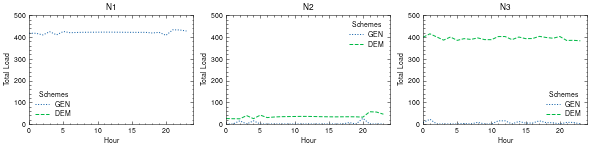

In [17]:
MARKET_RESULTS_GEN.sort_values(by=['Resource', 'Hour'], inplace=True)
MARKET_RESULTS_DEM.sort_values(by=['Resource', 'Hour'], inplace=True)

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2))

    i=0
    for n in sorted(N):
        ax[i].plot([t for t in T], [MARKET_RESULTS_NODE.at[(n, t), 'Generation'] for t in T], label='GEN', linestyle='dotted')
        ax[i].plot([t for t in T], [MARKET_RESULTS_NODE.at[(n, t), 'Demand'] for t in T], label='DEM', linestyle='dashed')
        ax[i].set_title(n)
        ax[i].set(xlabel ='Hour', ylabel ='Total Load', xlim =(0, 24), ylim =(0, 500)) #title =...
        ax[i].legend(title='Schemes', loc = 'best')
        i+=1
    fig.savefig(scenario + 'system_load.jpg', dpi=300)
        

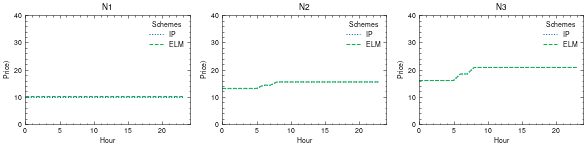

In [18]:
# prices over time
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2))

    i=0
    for n in sorted(N):
        ax[i].plot([t for t in T], [ip_prices.at[(n, t), 'Price'] for t in T], label='IP', linestyle='dotted')
        ax[i].plot([t for t in T], [elmp_prices.at[(n, t), 'Price'] for t in T], label='ELM', linestyle='dashed')
        ax[i].set_title(n)
        ax[i].set(xlabel ='Hour', ylabel ='Price)', xlim =(0, 24), ylim =(0, 40)) #title =...
        ax[i].legend(title='Schemes', loc = 'upper right')
        i+=1
    fig.savefig(scenario + '_prices.jpg', dpi=300)      

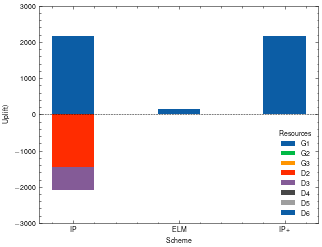

In [19]:
# financial balance 
# note: financial balance is the only design criteria that is not fulfilled

schemes = ['IP', 'ELM']#, 'CH']
values_g1 = [ip_uplifts_grouped.at['G1', 'Uplift'], elmp_uplifts.at['G1', 'Uplift'], ip_uplifts_grouped.at['G1', 'Uplift+']]
values_g2 =[ip_uplifts_grouped.at['G2', 'Uplift'], elmp_uplifts.at['G2', 'Uplift'], ip_uplifts_grouped.at['G2', 'Uplift+']]
values_g3 =[ip_uplifts_grouped.at['G3', 'Uplift'], elmp_uplifts.at['G3', 'Uplift'],ip_uplifts_grouped.at['G3', 'Uplift+']]
values_d31 =[ip_uplifts_grouped.at['D3.1', 'Uplift'], elmp_uplifts.at['D3.1', 'Uplift'],ip_uplifts_grouped.at['D3.1', 'Uplift+']]
values_d32 =[ip_uplifts_grouped.at['D3.2', 'Uplift'], elmp_uplifts.at['D3.2', 'Uplift'],ip_uplifts_grouped.at['D3.2', 'Uplift+']]
values_d33 =[ip_uplifts_grouped.at['D3.3', 'Uplift'], elmp_uplifts.at['D3.3', 'Uplift'],ip_uplifts_grouped.at['D3.3', 'Uplift+']]
values_d34 =[ip_uplifts_grouped.at['D3.4', 'Uplift'], elmp_uplifts.at['D3.4', 'Uplift'],ip_uplifts_grouped.at['D3.4', 'Uplift+']]
values_d35 =[ip_uplifts_grouped.at['D3.5', 'Uplift'], elmp_uplifts.at['D3.5', 'Uplift'],ip_uplifts_grouped.at['D3.5', 'Uplift+']]

data = np.array([values_g1, values_g2, values_g3, values_d31, values_d32, values_d33, values_d34, values_d35])
data_shape = np.shape(data)

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d  

cumulated_data = get_cumulated_array(data, min=0)
cumulated_data_neg = get_cumulated_array(data, max=0)

# Re-merge negative and positive data.
row_mask = (data<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

cols = ['IP', 'ELM', 'IP+']
resources =['G1', 'G2', 'G3', 'D2', 'D3', 'D4', 'D5', 'D6']

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1, figsize=(5, 4))

    for i in np.arange(0, data_shape[0]):
        ax.bar(cols, data[i], width=0.4, bottom=data_stack[i], label=resources[i])  
    ax.set(xlabel ='Scheme', ylabel ='Uplift)', ylim =(-3000, 3000)) #title =...
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.legend(title='Resources', loc = 'lower right')
    fig.savefig(scenario + 'uplifts.jpg', dpi=300)    